In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import subprocess

hpc030
Leipzig Cluster detected!
/mnt/archgen/users/pflorence/internship_new
CPU Count: 128


In [ ]:
from IBDecay.utils import create_stats
from IBDecay.plots import Plotter
from IBDecay.expectations import Calculator, Estimator

plotter = Plotter(chromosome_lengthsM_macaque)
calculator = Calculator(chromosome_lengthsM_macaque)
estimator = Estimator(chromosome_lengthsM_macaque)

In [ ]:
chromosome_lengthsBP_macaque = [ 223616716, 196192209, 185287830, 169962632, 
                187314383, 179082969, 169867068, 145676177, 
                134123906, 99508945, 133063178, 130042031, 
                108732418, 128052760, 113274796, 79622849, 
                95424395, 74473312, 58315217, 77134767]

chromosome_lengthsM_macaque = [1.0426104, 0.9114943, 0.88774445, 0.9821343,
                0.8610165399999999, 0.8323678, 0.9808, 0.6987766000000001,
                0.7982016000000001, 0.56821987, 0.7563325000000001, 0.60809906,
                0.63967335, 0.60983124, 0.6090937000000001, 0.48101673,
                0.6244356, 0.4388225, 1.0864966, 0.43828705]

genome_lengthM = sum(chromosome_lengthsM_macaque)

# Load csv

In [ ]:
### Cayo Santiago data
df_roh_cayo = pd.read_csv("98CayoRhesus.roh.csv")
df_roh_merged_cayo = pd.read_csv("98CayoRhesus.roh.merged.csv")
df_meta_cayo = pd.read_csv("metadataCayo.csv")

df_stats_cayo = create_stats(df_roh_merged_cayo, data_type='ROH', L=[4,8,12,16,20])
df_stats_cayo["F_roh8"] = df_stats_cayo["sum_ROH>8"] / genome_lengthM
df_stats_cayo["F_roh4"] = df_stats_cayo["sum_ROH>4"] / genome_lengthM

for df in [df_roh_cayo, df_roh_merged_cayo, df_stats_cayo]:
    df["id_vcf"] = df["iid"].astype(str).str.split(".", n=1).str[0]

In [11]:
# exclude a likely contaminated sample
df_meta_cayo = df_meta_cayo.loc[df_meta_cayo["id_animal"]!="I0515O"]

In [12]:
# filter only the animals from the metadata (published hich quality data)
df_roh_cayo = df_roh_cayo.loc[df_roh_cayo["id_vcf"].isin(df_meta_cayo["id_vcf"])]
df_roh_merged_cayo = df_roh_merged_cayo.loc[df_roh_merged_cayo["id_vcf"].isin(df_meta_cayo["id_vcf"])]
df_stats_cayo = df_stats_cayo.merge(df_meta_cayo[["id_vcf", "id_ccg"]].astype(str), on="id_vcf", how="right").fillna(0).sort_values("sum_ROH>4", ascending=False).reset_index(drop=True)

In [ ]:
### Chinese data
df_roh_china = pd.read_csv("79wildChineseRhesus.roh.csv")
df_roh_merged_china = pd.read_csv("79wildChineseRhesus.roh.merged.csv")
df_meta_china = pd.read_csv("metadataChina.csv", sep='\t')
df_meta_china = df_meta_china.loc[~df_meta_china["iid"].isin(["CR1", "CR2"])]

df_stats_china = create_stats(df_roh_merged_china, data_type='ROH', L=[4,8,12,16,20])
df_stats_china = df_stats_china.merge(df_meta_china["iid"], on="iid", how="right").fillna(0).sort_values("sum_ROH>4", ascending=False)
df_stats_china["F_roh8"] = df_stats_china["sum_ROH>8"] / genome_lengthM
df_stats_china["F_roh4"] = df_stats_china["sum_ROH>4"] / genome_lengthM

In [14]:
dataset = {
    "Cayo": {
        "df_roh": df_roh_cayo,
        "df_roh_merged": df_roh_merged_cayo,
        "df_meta": df_meta_cayo,
        "df_stats": df_stats_cayo
    },
    "China": {
        "df_roh": df_roh_china,
        "df_roh_merged": df_roh_merged_china,
        "df_meta": df_meta_china,
        "df_stats": df_stats_china
    }
}

# Visualize Results

## Histograms at population level

Estimated Ne in Cayo: 402.8018652917366 with 95% CI: (369.6426327632011, 439.91079362943117)


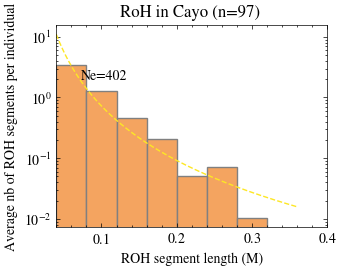

In [15]:
site = "Cayo"

expected_Ne, CI_Ne = estimator.estimate_Ne(dataset[site]["df_roh_merged"]["lengthM"], data_type="ROH", min_l=0.04, nb_observations=len(dataset[site]["df_meta"]))
print(f"Estimated Ne in {site}: {expected_Ne} with 95% CI: {CI_Ne}")

fig, ax = plotter.plot_histo(dataset[site]["df_roh_merged"], nb_normalize=len(dataset[site]["df_meta"]), bins=np.arange(0.04, 0.40, 0.04), Ne=[expected_Ne], data_type='ROH')
ax.set_title(f"RoH in {site} (n={len(dataset[site]['df_meta'])}) ")
fig.show()

Estimated Ne in China: 433.5722474213062 with 95% CI: (393.01337096630755, 479.7253336387523)


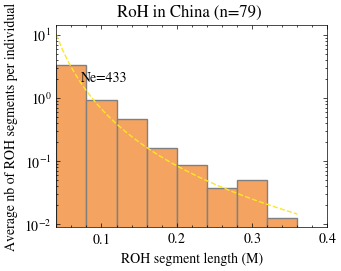

In [16]:
site = "China"

expected_Ne, CI_Ne = estimator.estimate_Ne(dataset[site]["df_roh_merged"]["lengthM"], data_type="ROH", min_l=0.04, nb_observations=len(dataset[site]["df_meta"]))
print(f"Estimated Ne in {site}: {expected_Ne} with 95% CI: {CI_Ne}")

fig, ax = plotter.plot_histo(dataset[site]["df_roh_merged"], nb_normalize=len(dataset[site]["df_meta"]), bins=np.arange(0.04, 0.40, 0.04), Ne=[expected_Ne], data_type='ROH')
ax.set_title(f"RoH in {site} (n={len(dataset[site]['df_meta'])}) ")
fig.show()

### Same at chinese subpopulation level

In [17]:
subspecies = ['tcheliensis', 'brevicaudus', 'littoralis', 'lasiotis', 'mulatta']

# plot the chinese ROH
for i, subspecie in enumerate(subspecies):
    iids = df_meta_china[df_meta_china["subspecie"]==subspecie]["iid"]
    lengths = df_roh_merged_china[df_roh_merged_china["iid"].isin(iids)]["lengthM"]
    Ne, CI_Ne = estimator.estimate_Ne(lengths, data_type="ROH", min_l=0.04, nb_observations=len(iids))
    print(f"{subspecie}:\tN_e={round(Ne)}\t {CI_Ne}\t {len(iids)}")

tcheliensis:	N_e=110	 (88.24877178498777, 139.04767796728876)	 5
brevicaudus:	N_e=250	 (185.63653715282203, 345.7265188165362)	 5
littoralis:	N_e=493	 (414.43785059052885, 591.2939616096608)	 28
lasiotis:	N_e=496	 (420.28017822695944, 589.6039866552628)	 31
mulatta:	N_e=7699	 (2962.1462843375093, 30986.931863019792)	 10


In [ ]:
def plot_roh_distribution(bins, ax=None, Nes=[100, 200, 500, 4000], Nes_text=True):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    bin_mids = (bins[:-1]+bins[1:])/2
    offset = 0.2

    # plot the Cayo ROH
    iids = df_meta_cayo
    lengths = df_roh_merged_cayo["lengthM"]
    y = np.histogram(lengths, bins=bins)[0]
    x = 100 * bin_mids[y>0] - 2.5 * offset
    y = y[y>0]
    ax.errorbar(x, y/len(iids), np.sqrt(y)/len(iids), marker='.', label="Cayo", zorder=10)

    # plot the chinese ROH
    for i, subspecie in enumerate(subspecies):
        iids = df_meta_china[df_meta_china["subspecie"]==subspecie]["iid"]
        lengths = df_roh_merged_china[df_roh_merged_china["iid"].isin(iids)]["lengthM"]
        y = np.histogram(lengths, bins=bins)[0]
        x = 100 * bin_mids[y>0] + (i-1.5) * offset
        y = y[y>0]
        ax.errorbar(x, y/len(iids), np.sqrt(y)/len(iids), marker='.', label=subspecie)

    # plot expectations for various Ne
    x = np.linspace(bin_mids[0], bin_mids[-1], 100)
    for Ne in Nes:
        y = calculator.roh_density_Ne(x, Ne) * (bins[1]-bins[0])
        ax.plot(100*x, y, color='darkgray', scaley=False, zorder=-1, linestyle='--', marker='')
        r = 0
        if Nes_text:
            pos = -12
            ax.text(100*x[pos], y[pos], f"{Ne}", color='darkgray',
                    rotation=r, rotation_mode='anchor', fontsize=8,
                    horizontalalignment='left',
                    verticalalignment='bottom')

    ax.set_yscale('log')
    # ax.set_xticks(bin_mids*100)
    ax.set_xticks(bins*100)
    ax.tick_params(axis='x', which='minor', bottom=False, top=False)

    return fig, ax

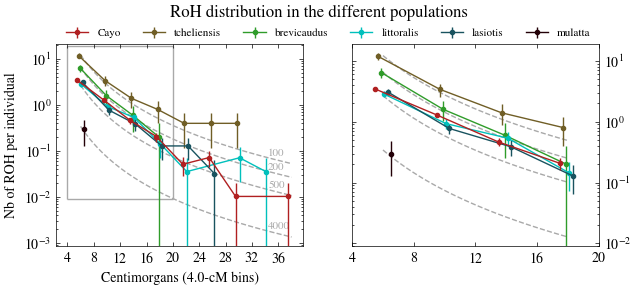

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(7, 2.625))
ax1, ax2 = axes

# plot overview
bins = np.arange(0.04, 0.44, 0.04)
plot(bins, ax1)
ax1.legend(bbox_to_anchor=(0, 0.98), loc='lower left', fontsize=8, ncols=6)
ax1.set_xlabel(f"Centimorgans ({100*(bins[1]-bins[0])}-cM bins)")
ax1.set_ylabel("Nb of ROH per individual")

# plot zoom
bins = np.arange(0.04, 0.24, 0.04)
ax2.tick_params(labelleft=False, labelright=True)
plot(bins, ax2, Nes_text=False)

# add zoom location in overview
xlim = ax2.get_xlim()
ylim = ax2.get_ylim()
ax1.hlines(ylim[0], xlim[0], xlim[1], color='darkgray', zorder=-1)
ax1.hlines(ylim[1], xlim[0], xlim[1], color='darkgray', zorder=-1)
ax1.vlines(xlim[0], ylim[0], ylim[1], color='darkgray', zorder=-1)
ax1.vlines(xlim[1], ylim[0], ylim[1], color='darkgray', zorder=-1)

fig.suptitle("RoH distribution in the different populations", y=1.03)
fig.show()

## RoH for one individual

### Overview of the genome

In [22]:
site = "China"

df_roh = dataset[site]["df_roh"]
df_roh_merged = dataset[site]["df_roh_merged"]
df_stats = dataset[site]["df_stats"]

In [ ]:
### Select the sample of interest
# Cayo sample likely contaminated (inbred individual with heterozygous snips within the ROH)
id_vcf = '194298'

# Most inbred individual
id_vcf = df_stats['iid'][df_stats['sum_ROH>4'].idxmax()]

# Chinese sample without ROH
id_vcf = 'C_rhe_26'

In [ ]:
# Get the ROH of the sample
df_sample = df_roh[df_roh["iid"] == id_vcf]
df_sample_merged = df_roh_merged[df_roh_merged["iid"] == id_vcf]

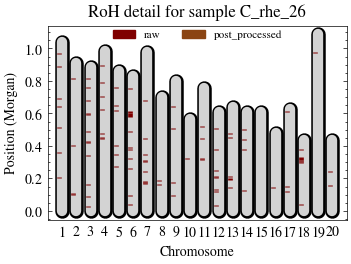

In [ ]:
fig, ax = plotter.plot_all_chromosomes(df_roh=df_sample, df_roh2=df_sample_merged, legend=("raw", "post_processed"))
ax.set_title(f"RoH detail for sample {id_vcf.split('.')[0]}")
fig.show()

### Detail of heterozygous SNPs

In [ ]:
chromosomes = [4]
chromosomes = [i for i in range(1, 21)]

In [27]:
def get_sample_het(id_vcf:str, vcf_file:str, chrom:int|None=None):
    if chrom is None:
        cmd = ["bcftools", "query", "-s", id_vcf, "-f", "%CHROM\t%POS[\t%GT]\n", vcf_file]
    else:
        cmd = ["bcftools", "query", "-s", id_vcf, "-r", str(chrom), "-f", "%CHROM\t%POS[\t%GT]\n", vcf_file]
    df = pd.read_csv(
        subprocess.Popen(cmd, stdout=subprocess.PIPE).stdout,
        sep="\t",
        header=None,
        names=['ch', 'posBP', 'GT']
    )
    x = df['GT'].str
    df['het'] = x[0] != x[2]
    return df

def load_genetic_map(file:str)->pd.DataFrame:
    """Load genetic map file and return a dataframe with columns: 'pos' (bp), 'cM' (centiMorgan)"""
    df = pd.read_csv(file, sep=" ", comment="#", header=0, usecols=[0,2])
    return df

def interpol_gen_pos(x, genetic_map:pd.DataFrame):
    """Interpolate genetic positions (cM) for given physical positions (bp) using the genetic map dataframe"""
    return 0.01 * np.interp(x, genetic_map['position'], genetic_map['Genetic_Map(cM)'] )

In [28]:
# extract sample heterozygosity from vcf
if site == "Cayo":
    df_het = []
    for chrom in chromosomes:
        vcf_file = f"data/vcf/ch{chrom}.vcf.gz"
        df_het.append(get_sample_het(id_vcf, vcf_file, chrom))
    df_het = pd.concat(df_het, ignore_index=True)
elif site == "China":
    vcf_file = f"data/chinese_genomes/79wildChineseRhesus_mmul10.vcf.gz"
    df_het = get_sample_het(id_vcf, vcf_file, chrom=None)

# add genetic positions
for chrom in chromosomes:
    map_file = f"data/genetic_map/chr{chrom}.txt"
    genetic_map = load_genetic_map(map_file)
    mask = df_het["ch"]==chrom
    df_het.loc[mask, "posM"] = interpol_gen_pos(df_het.loc[mask, "posBP"].values, genetic_map)

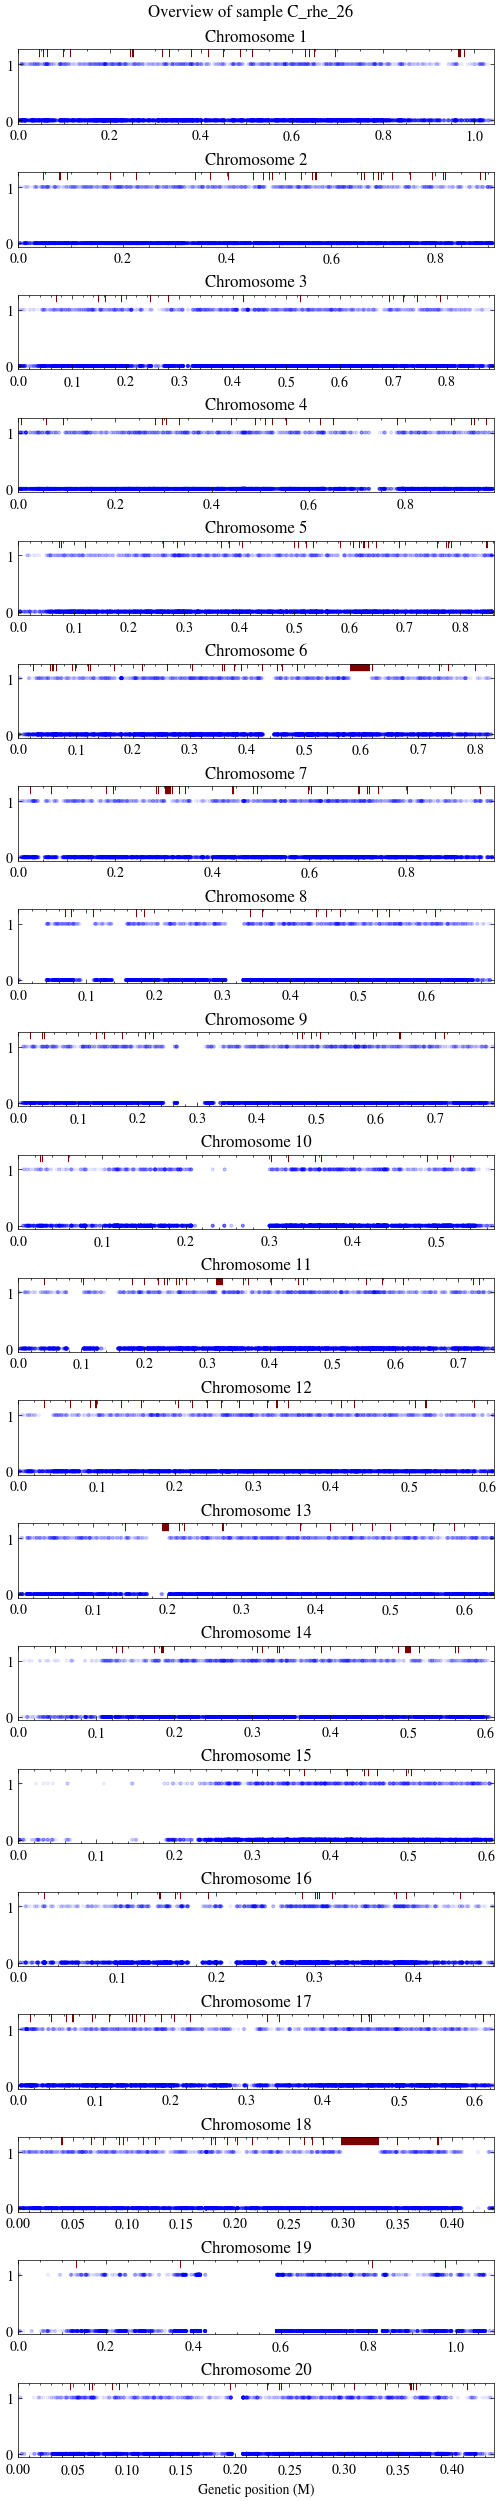

In [ ]:
fig, axes = plotter.plot_chromosome_detail(df_roh=df_sample, df_roh_2=df_sample_merged, df_het=df_het,
                             unit='M', chrom_length=chromosome_lengthsM_macaque, max_points=1e4,
                             chrom=None, figsize=(5, 25))
fig.suptitle(f"Overview of sample {id_vcf}")
fig.show()

## General population plots

### For Cayo

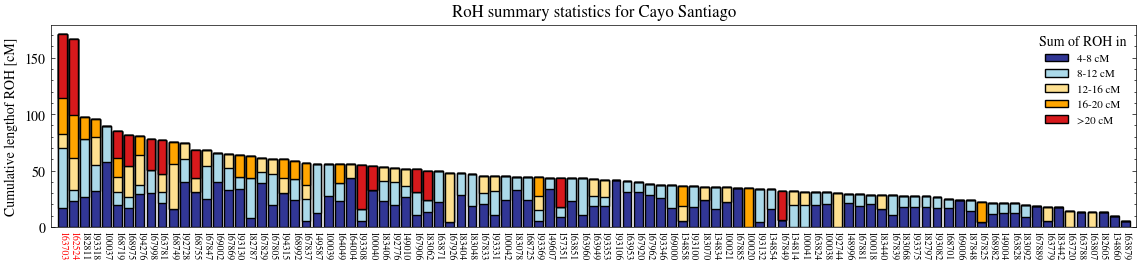

In [ ]:
fig, ax = plt.subplots(figsize=(14, 2.625))
plotter.plot_summary_stats(df_stats_cayo, ax=ax, L=[4,8,12,16,20], L_colors=["#313695", "#abd9e9", "#fee090", "orange", "#d7191c"], legend=True, x_ticks="id_ccg", y_ticks=True)

### change ticks to red for highly inbred animals
X = df_stats_cayo[df_stats_cayo["sum_ROH>16"]>(0.05*genome_lengthM)].index
for x in X:
    ax.get_xticklabels()[x].set_color("red")

ax.set_title("RoH summary statistics for Cayo Santiago")
fig.show()

### For China

In [33]:
subspecies = ['tcheliensis', 'brevicaudus', 'littoralis', 'lasiotis', 'mulatta']
df_subspecies = []

for subspecie in subspecies:
    iids = df_meta_china[df_meta_china["subspecie"]==subspecie]["iid"]
    df_sub = df_stats_china[df_stats_china["iid"].isin(iids)]
    df_subspecies.append(df_sub)

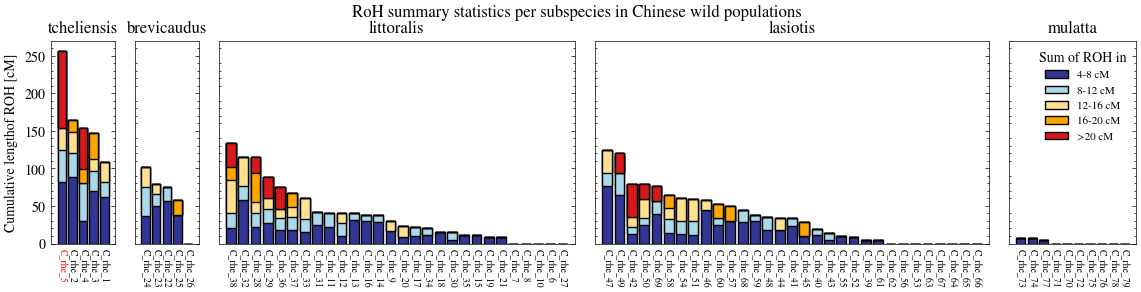

In [ ]:
fig, axes = plotter.plot_summary_stats_panel(df_subspecies, L=[4,8,12,16,20], L_colors=["#313695", "#abd9e9", "#fee090", "orange", "#d7191c"], titles=subspecies, x_ticks="iid", figsize=(14, 2.625))

### change ticks to red for highly inbred animals
axes = fig.get_axes()
axes[0].get_xticklabels()[0].set_color("red")

fig.suptitle("RoH summary statistics per subspecies in Chinese wild populations", y=1.02)
fig.show()

## Comparison with pedigree data

In [36]:
# add metadata to the stats for plotting
df_plot = df_stats_cayo.merge(
    df_meta_cayo[["id_vcf", "F_ped", "known_gen_2", "label", "kinlabel"]],
    on="id_vcf", how="left")

# keep individuals with all known grandparents
df_plot_filtered = df_plot[(df_plot["known_gen_2"]==4) & (~(df_plot["F_ped"].isna()))]
df_plot.loc[(df_plot["known_gen_2"]<4) | df_plot["F_ped"].isna(), "label"] = "unknown"

In [37]:
# nb of individuals with multiple loops
print(f"Nb considered samples: {len(df_plot_filtered)}")
print(f"Nb of samples with multiple loops: {(df_plot_filtered['kinlabel'].str.split('/@/').apply(lambda x: len(x))>1).sum()}")

Nb considered samples: 63
Nb of samples with multiple loops: 30


In [38]:
labels = ['half 1st-cousins', 'half 1st-cousins-once-removed', 'half 2nd-cousins', 'half 3rd-cousins', 'nonkin']

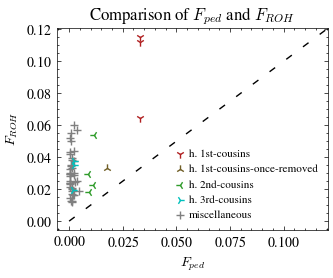

In [ ]:
markers = ['1', '2', '3', '4', '+', 'x']
marker = itertools.cycle(markers)

fig, ax = plt.subplots()

for label in labels[:-1]:
    df = df_plot_filtered[df_plot_filtered["label"]==label]
    label_short = label.replace("half ", "h. ")
    ax.scatter(df["F_ped"], df["F_roh4"], label=label_short, marker=next(marker))
df = df_plot_filtered[~df_plot_filtered["label"].isin(labels)]
ax.scatter(df["F_ped"], df["F_roh4"], label="miscellaneous", color="gray", zorder=-1, marker=next(marker))

max_val = np.max(df_plot_filtered[["F_ped", "F_roh4"]].max())

ax.plot([0,1],[0,1], ls=(0, (5, 10)), color='k')
ax.set_xlim(-0.05*max_val, 1.05*max_val)
ax.set_ylim(-0.05*max_val, 1.05*max_val)

ax.legend(loc="lower right", handletextpad=-0.2)
ax.set_title(r"Comparison of $F_{ped}$ and $F_{ROH}$")
ax.set_xlabel(r"$F_{ped}$")
ax.set_ylabel(r"$F_{ROH}$")
fig.show()

## Comparison of sum/number of ROH

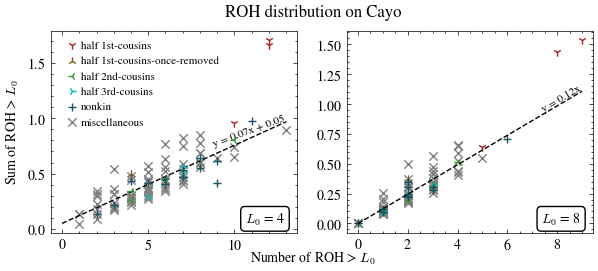

In [ ]:
markers = ['1', '2', '3', '4', '+', 'x']

fig, axes = plt.subplots(1, 2, figsize=(7, 2.625))
reg = []

# plot Cayo data
for i, cutoff in enumerate([4, 8]):
    marker = itertools.cycle(markers)
    ax = axes[i]
    for label in labels:
        df = df_plot[df_plot["label"]==label]
        ax.scatter(df[f"count_ROH>{cutoff}"], df[f"sum_ROH>{cutoff}"], label=label, marker=next(marker), zorder=-i)
    df = df_plot[~df_plot["label"].isin(labels)]
    ax.scatter(df[f"count_ROH>{cutoff}"], df[f"sum_ROH>{cutoff}"], label="miscellaneous", color="gray", zorder=-10, marker=next(marker))

    # linear regression
    df = df_plot[df_plot["sum_ROH>16"] < 0.05*genome_lengthM]
    x = df[f"count_ROH>{cutoff}"].values
    y = df[f"sum_ROH>{cutoff}"].values
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    x_fit = np.array([0, df_plot[f"count_ROH>{cutoff}"].max()])
    y_fit = m * x_fit + c
    ax.plot(x_fit, y_fit, color='black', linestyle='--', zorder=-1)

axes[0].set_ylabel(r"Sum of ROH > $L_0$")
fig.text(0.5, 0, r"Number of ROH > $L_0$", ha="center")

axes[0].legend(loc="upper left", handletextpad=-0.2)
fig.suptitle("ROH distribution on Cayo")
fig.show()

Linear regression for cutoff 4: y = 0.08x + 0.00
Linear regression for cutoff 8: y = 0.14x + -0.01


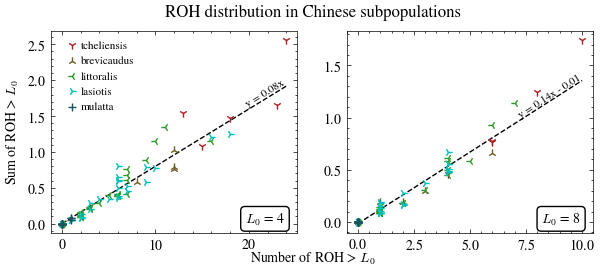

In [ ]:
markers = ['1', '2', '3', '4', '+', 'x']

fig, axes = plt.subplots(1, 2, figsize=(7, 2.625))

# plot China data
for i, cutoff in enumerate([4, 8]):
    marker = itertools.cycle(markers)
    ax = axes[i]
    subspecies = ['tcheliensis', 'brevicaudus', 'littoralis', 'lasiotis', 'mulatta']
    for subspecie in subspecies:
        iids = df_meta_china[df_meta_china["subspecie"]==subspecie]["iid"]
        df = df_stats_china[df_stats_china["iid"].isin(iids)]
        ax.scatter(df[f"count_ROH>{cutoff}"], df[f"sum_ROH>{cutoff}"], label=subspecie, marker=next(marker))

    # linear regression
    df = df_stats_china[df_stats_china["sum_ROH>16"] < 0.05*genome_lengthM]
    x = df[f"count_ROH>{cutoff}"].values
    y = df[f"sum_ROH>{cutoff}"].values
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    x_fit = np.array([0, df_stats_china[f"count_ROH>{cutoff}"].max()])
    y_fit = m * x_fit + c
    ax.plot(x_fit, y_fit, color='black', linestyle='--', zorder=-1)
    print(f"Linear regression for cutoff {cutoff}: y = {m:.2f}x + {c:.2f}")

axes[0].set_ylabel(r"Sum of ROH > $L_0$")
fig.text(0.5, 0, r"Number of ROH > $L_0$", ha="center")

axes[0].legend(loc="upper left", handletextpad=-0.2)
fig.suptitle("ROH distribution in Chinese subpopulations")
fig.show()

# Area 51

In [42]:
for subspecie in subspecies:
    iids = df_meta_china[df_meta_china["subspecie"]==subspecie]["iid"]
    df_sub = df_stats_china[df_stats_china["iid"].isin(iids)]
    x = (df_sub["sum_ROH>4"]==0).sum()
    print(f"For {subspecie}: {x}/{len(df_sub)}  ({x/len(df_sub)*100}%) without ROH")

For tcheliensis: 0/5  (0.0%) without ROH
For brevicaudus: 1/5  (20.0%) without ROH
For littoralis: 5/28  (17.857142857142858%) without ROH
For lasiotis: 8/31  (25.806451612903224%) without ROH
For mulatta: 7/10  (70.0%) without ROH


In [47]:
df_plot[['label', 'F_ped']].groupby('label').agg(['count', 'mean']).droplevel(0, axis=1).sort_values('mean', ascending=False)["count"]

label
half 1st-cousins                    3
half 1st-cousins-once-removed       1
half 2nd-cousins                    4
half 2nd-cousins-once-removed       2
half 2nd-cousins-twice-removed      7
half 3rd-cousins                    3
half 3rd-cousins-once-removed      16
unknown                            29
half 4th-cousins                    6
half 3rd-cousins-twice-removed      1
half 4th-cousins-once-removed       5
half 3rd-cousins-thrice-removed     1
half 5th-cousins                    1
nonkin                             13
Name: count, dtype: int64